In [1]:
import platform
import pandas as pd
import numpy as np
import os,re,sys
import chardet
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date,datetime,timedelta
import matplotlib.dates as mdates
import seaborn as sns
from jusho import Jusho
import matplotlib.ticker as ticker
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import _tree
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist  # 计算距离时
import pickle
import matplotlib.ticker as mticker

In [2]:
# data path
path_data = '/home/zhangmingming/Documents/Notebook/Data/220325'
path_model = '/home/zhangmingming/Documents/Notebook/Model/'
path_holiday = '/home/zhangmingming/Documents/Notebook/Data/Holiday'
path_weather = '/home/zhangmingming/Documents/Notebook/Data/Weather'

### 1. Get data

In [3]:
if os.path.exists(os.path.join(path_data, 'df_txn.csv')):
    df_txn = pd.read_csv(os.path.join(path_data, 'df_txn.csv'))
else:
    files = [file for file in os.listdir(path_data)]
    df_txn = pd.DataFrame()
    for file in files:
        df = pd.read_csv(os.path.join(path_data, file))
        df_txn = pd.concat([df_txn, df] , axis = 0, ignore_index = True)
    df_txn.to_csv(os.path.join(path_data, 'df_txn.csv'), index = False)

/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 2. 唐人店

In [4]:
df_txn_store  = df_txn[df_txn['salon_id'] == 54]     # 唐人店のsalon_id == 2
#df_txn_store  = df_txn

#### 2.1 月毎の来店顧客の人数を分析する

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


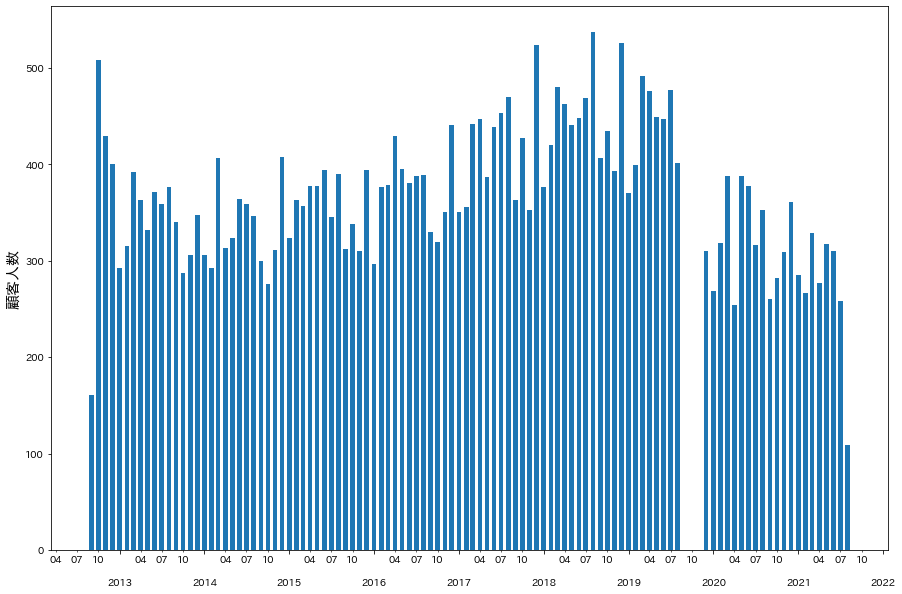

In [5]:
# 月毎の来店顧客の人数を分析する
df_txn_store.loc[:,'year'] = df_txn_store.apply(lambda x: x['date'][:4], axis = 1)
df_txn_store.loc[:,'month'] = df_txn_store.apply(lambda x: date(datetime.strptime(x['date'], '%Y/%m/%d').year, datetime.strptime(x['date'], '%Y/%m/%d').month, 1),axis = 1)
df_txn_store_month_cust = df_txn_store.groupby('month')['customer_id'].nunique().reset_index(name = 'cnt_cust')

# format the fig
years = mdates.YearLocator()
months = mdates.MonthLocator(interval=3)
monthsFmt = mdates.DateFormatter('%m') 
yearsFmt = mdates.DateFormatter('\n\n%Y')  # add some space for the year label

#sns.set_style(style='white')
fig, ax = plt.subplots(figsize = (15,10), facecolor='white')  
ax.bar(df_txn_store_month_cust['month'].tolist(), df_txn_store_month_cust['cnt_cust'].tolist(), width=20)
plt.ylabel('顧客人数', fontsize = 15)
ax.xaxis_date()
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
#plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

### 3. RFM を作ります

#### 3.1 初めて標準データを準備します

In [10]:
date_latest = df_txn_store['date'].max()

# 過去の一年間のデータを選ぶ
date_1yb    = (datetime.strptime(date_latest, '%Y/%m/%d') - timedelta(days = 3650)).strftime('%Y/%m/%d')
#f_txn_store[(df_txn_store['date'] <= date_latest)&(df_txn_store['date'] >= date_1yb)]['customer_id'].nunique()
df_txn_store_seg = df_txn_store[(df_txn_store['date'] <= date_latest)&(df_txn_store['date'] >= date_1yb)]
date_latest = datetime.strptime(date_latest, '%Y/%m/%d')
df_txn_store_seg['date'] = pd.to_datetime(df_txn_store_seg['date'])

# R-F-Mのデータを計算する
rfmTable = df_txn_store_seg.groupby('customer_id').agg({'date': lambda x: (date_latest - x.max()).days, # Recency
                                        'transaction_id': lambda x: len(set(x)),      # Frequency
                                        'amount': lambda x: x.sum()}) # Monetary Value
rfmTable['date'] = rfmTable['date'].astype(int)
rfmTable['amount'] = rfmTable['amount'].astype(float)
rfmTable.rename(columns={'date': 'recency', 
                         'transaction_id': 'frequency', 
                         'amount': 'monetary_value'}, inplace=True)

# 情報segmentation
quantiles = rfmTable.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
rfmSegmentation = rfmTable

# Recencyのsegmentの計算
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Frequency と　monetization のsegmentの計算
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# segmentaionの応用
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))
rfmSegmentation_Quar = rfmSegmentation[['R_Quartile', 'F_Quartile','M_Quartile']]

# RFM結果の１−０標準化
rfmSegmentation_H = rfmSegmentation_Quar.mean().to_dict()
rfmSegmentation_Quar.loc[:, 'R_Score'] = rfmSegmentation_Quar['R_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['R_Quartile'] else 0)
rfmSegmentation_Quar.loc[:, 'F_Score'] = rfmSegmentation_Quar['F_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['F_Quartile'] else 0)
rfmSegmentation_Quar.loc[:, 'M_Score'] = rfmSegmentation_Quar['M_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['M_Quartile'] else 0)

# 項目を選ぶ
rfmSegmentation_SCORE = rfmSegmentation_Quar[['R_Score', 'F_Score','M_Score']]

# 最後のRFM結果を整理する
df_txn_cust = df_txn_store[['customer_id']].drop_duplicates().reset_index(drop = True)
df_txn_cust = df_txn_cust.merge(rfmSegmentation_SCORE, left_on= 'customer_id', right_index= True, how = 'left')
df_txn_cust.fillna(0, inplace = True)

# 人数を計算する
RFM_result = df_txn_cust.groupby(['R_Score', 'F_Score','M_Score']).size().reset_index(name = 'population')
RFM_result.sort_values(by = ['M_Score', 'F_Score', 'R_Score'], ascending= False, inplace = True)

# 人数を計算する
RFM_result.index = ['既存な重要顧客','重要な潜在失客','潜在な重要顧客','重要な失客','潜在な顧客','新規顧客','一般的顧客','一般的失客']

# RFM 結果を整理する
df_part = RFM_result[['population']].transpose()
df_part.index = ['2022']

# create all RFM
df_RFM_all = df_part

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
df_part

,既存な重要顧客,重要な潜在失客,潜在な重要顧客,重要な失客,潜在な顧客,新規顧客,一般的顧客,一般的失客
2022,1919,918,211,492,246,226,1179,1914


In [7]:
split_recency = list(quantiles['recency'].values())[-int(np.ceil(rfmSegmentation_H['R_Quartile']) -1)]
split_frequency = list(quantiles['frequency'].values())[int(np.ceil(rfmSegmentation_H['F_Quartile']) -1)]
split_monetary = list(quantiles['monetary_value'].values())[int(np.ceil(rfmSegmentation_H['M_Quartile']) -1)]
print(f'高い recency は：　{split_recency} 以下')
print(f'高い frequency は：{split_frequency} 以上')
print(f'高い monetary は:　{split_monetary} 以上')

高い recency は：　1260.0 以下
高い frequency は：6.0 以上
高い monetary は:　12420.0 以上


#### 3.2 この前の数年のRFM結果を計算します

In [12]:
# 時間を選びます
year_min = int(df_txn_store['date'].min()[:4])
year_max = date_latest.year
month_rfm = date_latest.month
day_rfm = date_latest.day

# この前の数年のRFMモデルを計算する
for y in list(range(year_min+2, year_max)):
    
    # この前の数年のデータを選びます
    date_latest_part = date(y, month_rfm, day_rfm).strftime('%Y/%m/%d')
    date_1yb    = (datetime.strptime(date_latest_part, '%Y/%m/%d') - timedelta(days = 3650)).strftime('%Y/%m/%d')
    df_txn_store_seg = df_txn_store[(df_txn_store['date'] <= date_latest_part)&(df_txn_store['date'] >= date_1yb)]
    date_latest_part = datetime.strptime(date_latest_part, '%Y/%m/%d')
    df_txn_store_seg['date'] = pd.to_datetime(df_txn_store_seg['date'])
    
    # RFM情報を計算します
    rfmTable = df_txn_store_seg.groupby('customer_id').agg({'date': lambda x: (date_latest_part - x.max()).days, # Recency
                                            'transaction_id': lambda x: len(set(x)),      # Frequency
                                            'amount': lambda x: x.sum()}) # Monetary Value
    rfmTable['date'] = rfmTable['date'].astype(int)
    rfmTable['amount'] = rfmTable['amount'].astype(float)
    rfmTable.rename(columns={'date': 'recency', 
                             'transaction_id': 'frequency', 
                             'amount': 'monetary_value'}, inplace=True)
    
    # RFMセグメンテーションを計算します
    rfmSegmentation = rfmTable
    rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
    rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
    rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))
    rfmSegmentation = rfmSegmentation[['R_Quartile', 'F_Quartile','M_Quartile']]
    
    # RFM得点（１或いは０）を計算します
    rfmSegmentation.loc[:, 'R_Score'] = rfmSegmentation['R_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['R_Quartile'] else 0)
    rfmSegmentation.loc[:, 'F_Score'] = rfmSegmentation['F_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['F_Quartile'] else 0)
    rfmSegmentation.loc[:, 'M_Score'] = rfmSegmentation['M_Quartile'].apply(lambda x : 1 if x > rfmSegmentation_H['M_Quartile'] else 0)
    rfmSegmentation = rfmSegmentation[['R_Score', 'F_Score','M_Score']]
    
    # RFMの結果をまとめます
    df_txn_cust = df_txn_store[['customer_id']].drop_duplicates().reset_index(drop = True)
    df_txn_cust = df_txn_cust.merge(rfmSegmentation, left_on= 'customer_id', right_index= True, how = 'left')
    df_txn_cust.fillna(0, inplace = True)
    RFM_result_part = df_txn_cust.groupby(['R_Score', 'F_Score','M_Score']).size().reset_index(name = 'population')
    RFM_result_part = RFM_result[['R_Score', 'F_Score','M_Score']].reset_index().merge(RFM_result_part[['R_Score', 'F_Score','M_Score', 'population']], on = ['R_Score', 'F_Score','M_Score'], how = 'inner').set_index('index')
    df_part = RFM_result_part[['population']].transpose()
    df_part.index = [str(y)]
    df_RFM_all =  pd.concat([df_RFM_all, df_part], axis= 0)
    
# 全部の結果をまとめます（initialization）
df_RFM_all.sort_index(ascending= True, inplace= True)

/tmp/ipykernel_9477/3996594649.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_txn_store_seg['date'] = pd.to_datetime(df_txn_store_seg['date'])
/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

#### 3.3 RFMの過去の数年間の結果の可視化

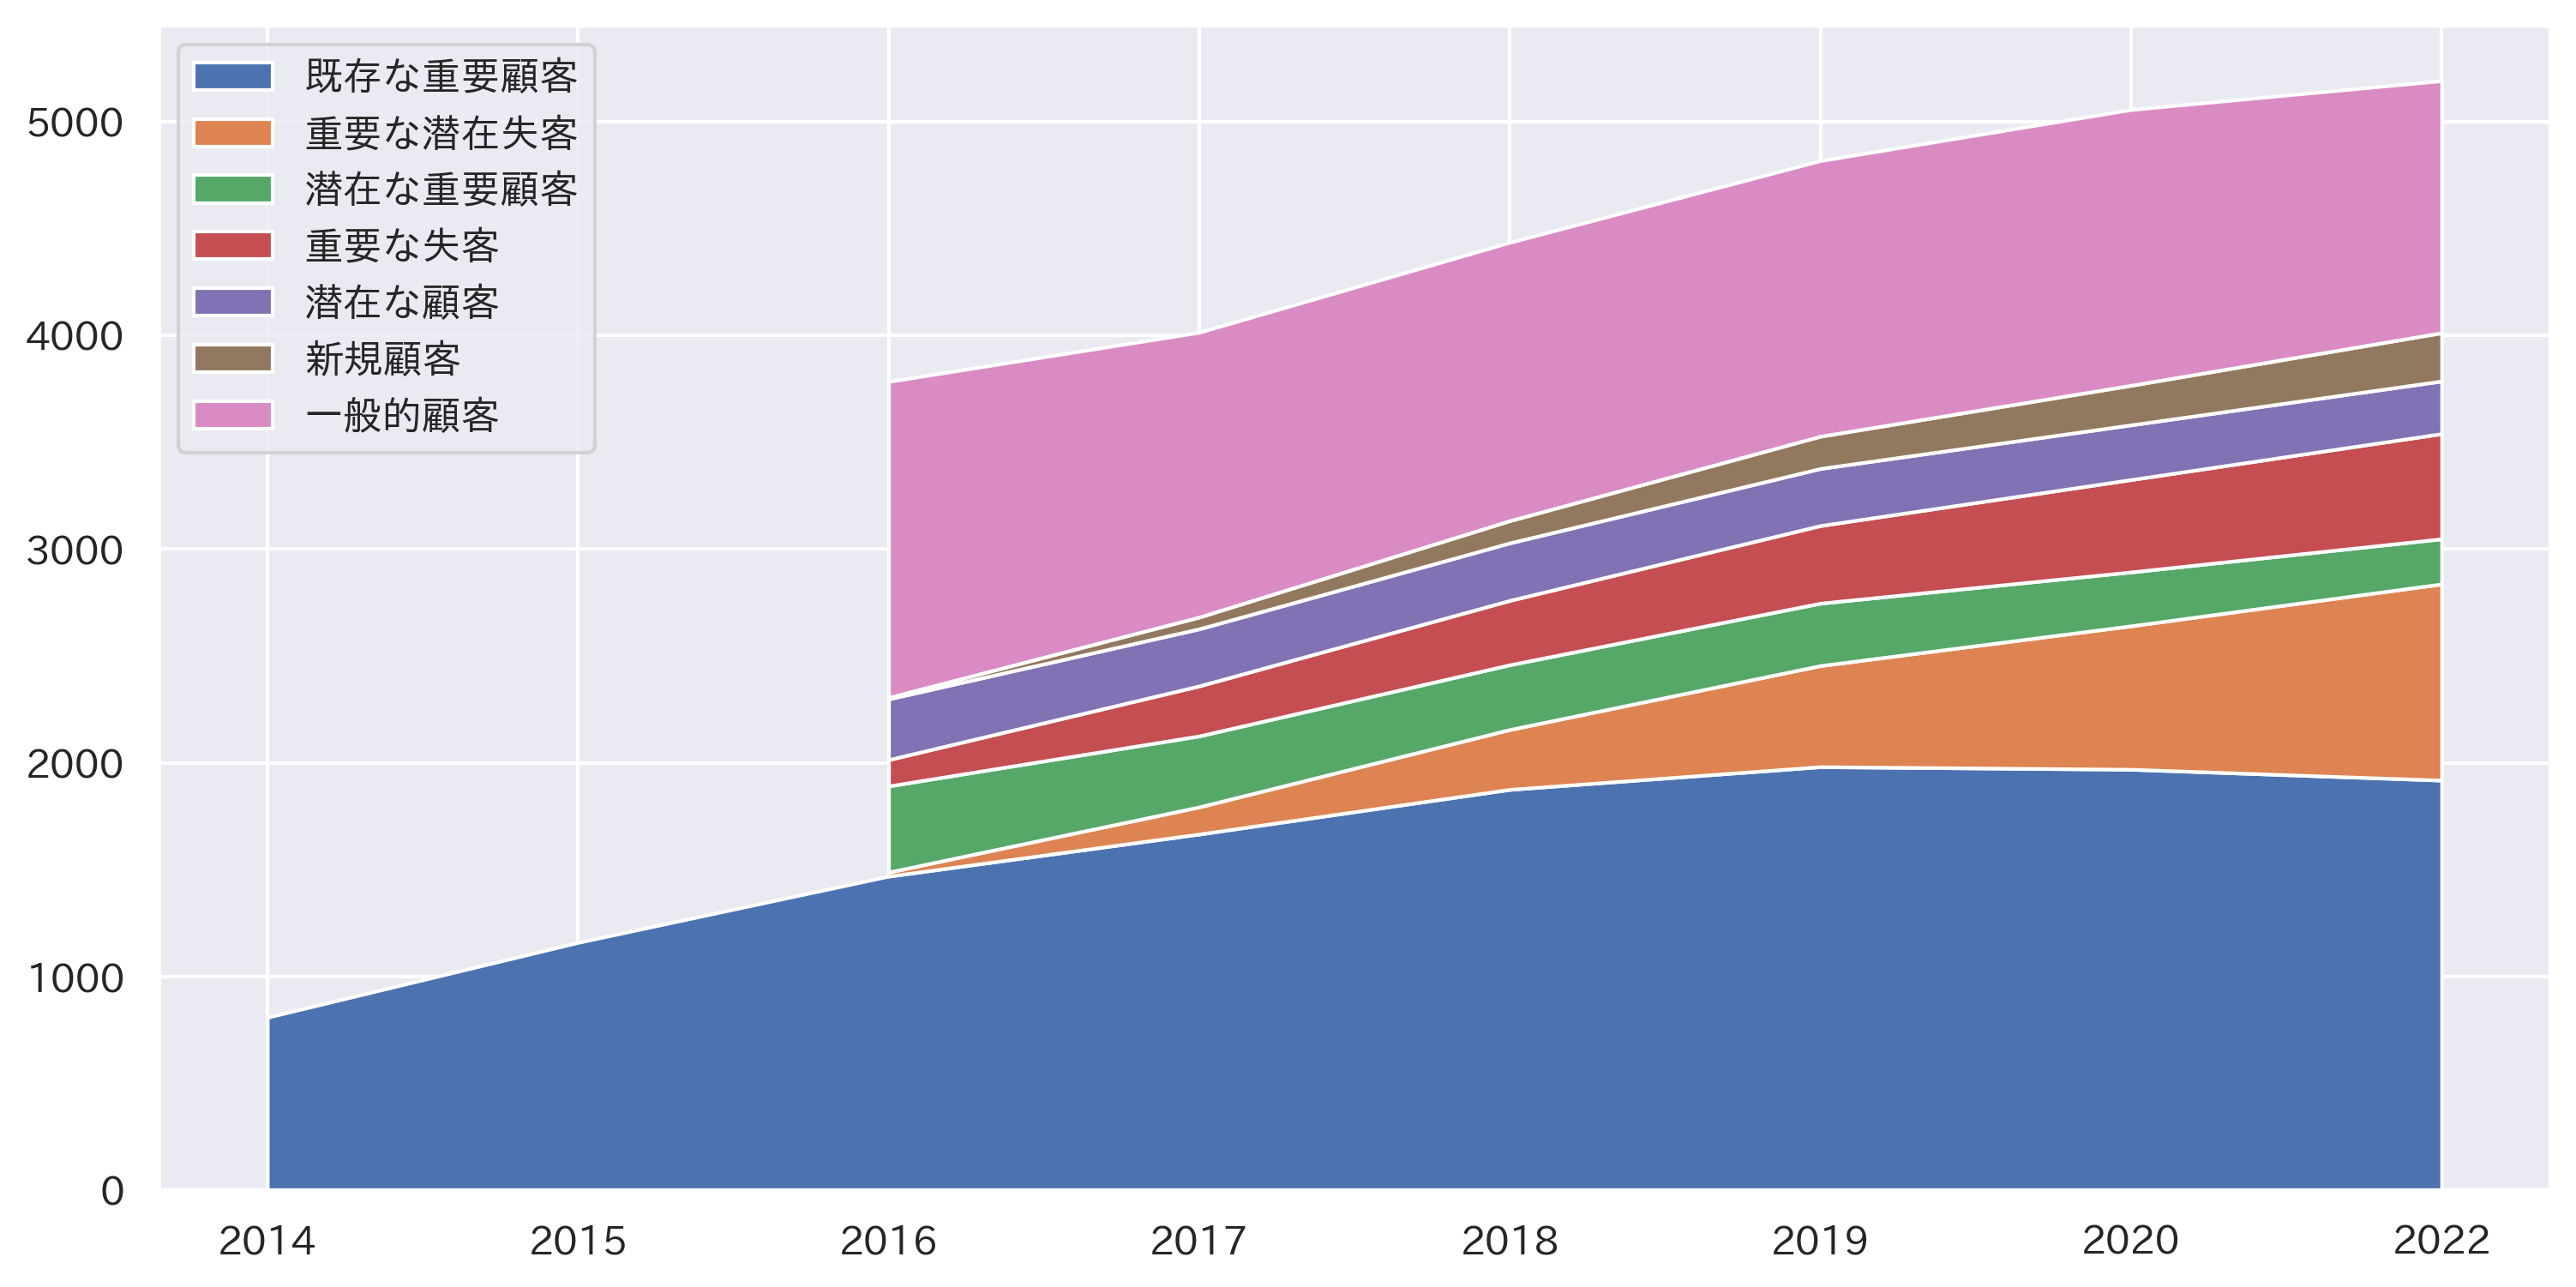

In [13]:
df_RFM_all_graph = df_RFM_all.iloc[:, :-1]
sns.set_theme()
sns.set(font_scale = 1, font='IPAexGothic')
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.stackplot(df_RFM_all_graph.index.tolist(),df_RFM_all_graph.to_numpy().transpose(1,0), labels=df_RFM_all_graph.columns.values)
plt.legend(loc='upper left')
plt.show()